In [70]:
pd.__version__

'1.4.1'

# Creating the Reddit Network of Climate Discussion Contributors 

Using the pre-trained Climate Change Sentiment classifier on submissions and comments from Redittors, we model a network of Redittors being pro, neutral or anti to Climate Change.


In [1]:
import os
from pathlib import Path
import time, datetime

import pickle
from collections import Counter

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

from nltk import word_tokenize, PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

from psaw import PushshiftAPI
import networkx as nx
import netwulf as nw

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.simplefilter("ignore", UserWarning)

## 1) Load Reddit data

Initially, the data extracted from Reddit is loaded.

In [2]:
# Data directory
DATA_DIR = Path(os.getcwd()).parent / 'data'

In [7]:
start = time.time()

# load data
comments = pd.read_json(DATA_DIR / 'reddit_comments90k.json.bz2')
submissions = pd.read_json(DATA_DIR / 'reddit_submissions.json.bz2')

end = time.time()
print(f"Took {end-start} seconds to load dataframe...")

Took 124.70616698265076 seconds to load dataframe...


In [8]:
submissions.shape

(572747, 11)

In [9]:
comments.shape

(1020327, 12)

## 2) Link comment authors to submission authors

In [10]:
# create dictionaries
comment_authors = dict(zip(comments.id, comments.author))
parent = dict(zip(comments.id, comments.parent_id))
submission_authors = dict(zip(submissions.id, submissions.author))

In [11]:
def parent_author(comment_id, comment_authors=comment_authors, parent=parent, submission_authors=submission_authors):
    '''Links the comment id to the author of its parent.
    
    input: comment_id
    returns: author'''
    
    parent_id = parent[comment_id]
    
    try: # try to look for the parent_id key
        if parent_id[:3] == 't1_':
            return comment_authors[parent_id[3:]]
        if parent_id[:3] == 't3_':
            return submission_authors[parent_id[3:]]    
    except KeyError: # if parent_id was not extracted in comments or submissions
        return np.nan

In [12]:
comments['parent_author'] = comments['id'].progress_apply(lambda x: parent_author(x))

  0%|          | 0/1020327 [00:00<?, ?it/s]

In [13]:
print(f"Number of IDs that could not be extracted: {comments['parent_author'].isnull().sum()}/{comments['parent_author'].__len__()} = {comments['parent_author'].isnull().sum() / comments['parent_author'].__len__() :.4f}")

Number of IDs that could not be extracted: 14208/1020327 = 0.0139


In [14]:
# remove NaN parent authors
comments = comments[-comments.parent_author.isnull()].reset_index(drop=True)

# size of data
comments.shape

(1006119, 12)

## 3) Filter the Reddit comments and submissions

In [15]:
# join title and selftext to text attribute in submissions
submissions['text'] = submissions.title + " " + submissions.selftext

In [16]:
# Remove NaN values for awarders by setting it to 0 or empty list
submissions['all_awardings'] = submissions['all_awardings'].fillna("").apply(list)
submissions['awarders'] = submissions['awarders'].fillna("").apply(list)
submissions['total_awards_received'] = submissions['total_awards_received'].fillna(0)

comments['all_awardings'] = comments['all_awardings'].fillna("").apply(list)
comments['total_awards_received'] = comments['total_awards_received'].fillna(0)

In [17]:
# filter comments and remove rows with deleted users
filtered_comments = comments

deleted_users_idx = np.logical_or(filtered_comments.author == '[deleted]', filtered_comments.parent_author == '[deleted]')
filtered_comments = filtered_comments[-deleted_users_idx]
print(f"Number of deleted users: {deleted_users_idx.sum()}")

# update index
filtered_comments.reset_index(drop=True, inplace=True)
filtered_comments.shape

Number of deleted users: 93413


(912706, 12)

In [18]:
# filter submissions and remove rows with deleted users
filtered_submissions = submissions

deleted_users_idx = filtered_submissions.author == '[deleted]'
filtered_submissions = filtered_submissions[-deleted_users_idx]
print(f"Number of deleted users: {deleted_users_idx.sum()}")

# update index
filtered_submissions.reset_index(drop=True, inplace=True)
filtered_submissions.shape

Number of deleted users: 15406


(557341, 12)

## 4) Handle author metadata 

In [17]:
def get_metadata(df, reddit_type='comment'):
    
    author_df = pd.DataFrame()
    
    groups = df.groupby(by='author')

    author_df['text'] = groups.text.progress_apply(lambda x: list(x))
    author_df['all_awardings'] = groups.all_awardings.progress_apply(lambda x: np.concatenate([*x]))
    author_df['total_awards_received'] = groups.total_awards_received.sum()
    author_df['total_awards_received'] = groups.total_awards_received.sum()
    author_df['score'] = groups.score.sum()
    author_df[f'first_{reddit_type}'] = groups.date.progress_apply(lambda x: x.sort_values(ascending=True).iloc[0])
    author_df[f'last_{reddit_type}'] = groups.date.progress_apply(lambda x: x.sort_values(ascending=True).iloc[-1])
    author_df[f'num_{reddit_type}s'] = groups.progress_apply(lambda x: x.__len__())
    
    if reddit_type == 'comment':
        author_df['controversiality'] = groups.controversiality.sum()
    
    return author_df

In [20]:
#extract metadata
print("Extracting metadata for comments...")
author_comment = get_metadata(filtered_comments, reddit_type='comment')

print("\nExtracting metadata for submissions...")
author_submission = get_metadata(filtered_submissions, reddit_type='submission')

Extracting metadata for comments...


  0%|          | 0/349021 [00:00<?, ?it/s]

  0%|          | 0/349021 [00:00<?, ?it/s]

  0%|          | 0/349021 [00:00<?, ?it/s]

  0%|          | 0/349021 [00:00<?, ?it/s]

  0%|          | 0/349021 [00:00<?, ?it/s]


Extracting metadata for submissions...


  0%|          | 0/170667 [00:00<?, ?it/s]

  0%|          | 0/170667 [00:00<?, ?it/s]

  0%|          | 0/170667 [00:00<?, ?it/s]

  0%|          | 0/170667 [00:00<?, ?it/s]

  0%|          | 0/170667 [00:00<?, ?it/s]

In [21]:
author_joined = author_comment.join(author_submission, on='author', lsuffix='_c', rsuffix='_s')

In [60]:
author = pd.DataFrame()
print("Running...")
for attr, fill in {'text': 'list', 'all_awardings': 'list', 'total_awards_received': 'num', 'score': 'num'}.items():
    for letter in ['s', 'c']:
        
        # reformat rows
        if fill == 'list':
            author_joined[f'{attr}_{letter}'] = author_joined[f'{attr}_{letter}'].fillna("").apply(list)
        elif fill == 'num':
            author_joined[f'{attr}_{letter}'] = author_joined[f'{attr}_{letter}'].fillna(0)
            
    # create combined dataframe
    author[f'{attr}'] = author_joined[f'{attr}_s'] + author_joined[f'{attr}_c']
print("Successfully combined dataframe!")

# keep relevant attributes
aoi = ['first_comment', 'last_comment', 
       'first_submission', 'last_submission', 
       'num_comments', 'num_submissions',  
       'controversiality']
author[aoi] = author_joined[aoi]

# modify list of texts to one large string
author['text'] = author['text'].progress_apply(lambda x: ' '.join(str(v) for v in x))

# rename
author = author.rename(columns={'controversiality':'comment_controversiality'})
author.sample(10)

Running...
Successfully combined dataframe!


  0%|          | 0/349021 [00:00<?, ?it/s]

,text,all_awardings,total_awards_received,score,first_comment,last_comment,first_submission,last_submission,num_comments,num_submissions,comment_controversiality
author,,,,,,,,,,,
A_Clever_Ape,That's a good article. The Cubans are doing go...,[],0.0,1.0,2022-01-29,2022-01-29,NaN,NaN,1,NaN,0.0
wysiwyg1999,When you have a political parasite telling oth...,[],0.0,2.0,2018-11-26,2018-11-26,NaN,NaN,1,NaN,0.0
FilthySnek,"yall be like ""yeah climate change is bad and w...",[],0.0,39.0,2019-07-17,2019-07-19,2019-07-17,2019-08-24,3,3.0,0.0
timpanzeez,Be a member of a group that publishes literatu...,[],0.0,1.0,2021-12-15,2021-12-15,NaN,NaN,1,NaN,0.0
rapscallionrodent,"From what I've read, there's no doubt that the...",[],0.0,1.0,2020-03-31,2020-03-31,NaN,NaN,1,NaN,0.0
bigsuzao,0x5084047075dAF25e51F7eC90533D76226B8061A9,[],0.0,1.0,2021-10-21,2021-10-21,NaN,NaN,1,NaN,0.0
usually_witty,I listened to the audio book so my memory is a...,[],0.0,2.0,2021-09-11,2021-09-11,NaN,NaN,1,NaN,0.0
jamieooo,I want to say climate change too. \n\nThe impa...,[],0.0,1.0,2021-12-27,2021-12-27,NaN,NaN,1,NaN,0.0
SavageNorth,"Probably because they’re American, it’s far le...",[],0.0,2.0,2019-11-28,2019-12-14,NaN,NaN,2,NaN,0.0


In [1]:
# load stop-words
stop_words = set(stopwords.words('english'))

# add webpages to stopwords
stop_words.add('http') 
stop_words.add('https')

# Preprocess the text 
porter = PorterStemmer()
exclusions = {'RT'}

# define tokenizing function
clean = lambda x: Counter([porter.stem(word_token).lower() for word_token in word_tokenize(x) \
                       if porter.stem(word_token) not in stop_words \
                       and word_token.isalpha() \
                       and word_token not in exclusions])

# apply tokenizing to texts - progress_apply for seeing progress bar WHEN running
tokens = author['text'].progress_apply(lambda text: clean(text))
author['tokens'] = tokens

# join tokens to one string
author['processed_text'] = author['tokens'].progress_apply(lambda x: ' '.join(str(v) for v in x))

In [ ]:
author.to_json(DATA_DIR / 'author_df.json.bz2')

# TODO: INVESTIGATE OPINION SCORE TO THE METADATA!

In [6]:
author = pd.read_json(DATA_DIR / 'author_df.json.bz2')

In [7]:
pkl_filename = Path(os.getcwd()).parent / 'model/RandomForest_TwitterOpinion.pkl'

with open(pkl_filename, 'rb') as file:
    model = pickle.load(file)

In [46]:
X = author['processed_text'].to_numpy()
opinions = ['NaN'] * X.__len__()

for i, x in enumerate(tqdm(X)):
    pred = model.predict([x])
    opinions[i] = pred[0]

author['opinion'] = opinions

  0%|          | 0/346273 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
author.to_json(DATA_DIR / 'author_opinion.json.bz2')

## 5) Create ClimateGraph from edgelist

In [3]:
author = pd.read_json(DATA_DIR / 'author_opinion.json.bz2')

In [19]:
author.sample(5)

,text,all_awardings,total_awards_received,score,first_comment,last_comment,first_submission,last_submission,num_comments,num_submissions,comment_controversiality,tokens,processed_text,opinion
catbertz,Well that sucks. I guess I'll go burn some shi...,[],0,1,1575417600000,1575417600000,NaN,NaN,1,NaN,0,"{'well': 1, 'suck': 1, 'i': 2, 'guess': 1, 'go...",well suck i guess go burn shit bbq eas pain im...,Neutral
thestorys0far,Got a source on that?\n\nAnd because X pollute...,[],0,2,1565049600000,1565049600000,NaN,NaN,2,NaN,0,"{'got': 1, 'sourc': 1, 'becaus': 1, 'x': 1, 'p...",got sourc becaus x pollut y also account globa...,Neutral
Staghound_,I feel the trick is picking items that all wor...,[],0,1,1433376000000,1433376000000,NaN,NaN,1,NaN,0,"{'i': 2, 'feel': 1, 'trick': 1, 'pick': 1, 'it...",i feel trick pick item work right,Neutral
jlgoodin78,I have an idea — let’s pass legislation that s...,[],0,1,1639872000000,1639872000000,NaN,NaN,1,NaN,0,"{'i': 1, 'idea': 1, 'let': 1, 'pass': 1, 'legi...",i idea let pass legisl state receiv feder fund...,Neutral
douggieboy,Fuck Aaron Hawkins eh. Such a virtue signallin...,[],0,1,1560124800000,1560124800000,NaN,NaN,1,NaN,0,"{'fuck': 1, 'aaron': 1, 'hawkin': 1, 'eh': 1, ...",fuck aaron hawkin eh virtu signal smarmi cunt,Neutral


In [5]:
Counter(author['opinion'])

Counter({'Neutral': 284862, 'Anti': 44423, 'Pro': 13847, 'News': 3141})

In [24]:
# computing the weighted edgelist by counting - using score as a randomly picked attributed to obtain a single pd.Series
weighted_edgelist = filtered_comments.groupby(by=['author', 'parent_author']).count().score
weighted_edgelist = weighted_edgelist.reset_index().rename(columns={'score':'weight'})

In [25]:
weighted_edgelist.sample(5, random_state=42)

,author,parent_author,weight
380985,VeggiesForThought,FirmFarmer,1
339795,SuperOrganizer,ReadShift,1
494217,fatcity,DrFaustPhD,1
592195,namrock23,last-resort-4-a-gf,1
663215,staycurrent,SkyIcewind,1


In [22]:
# reformat weighted edgelist to 3-tuples
edgelist = list(zip(weighted_edgelist.author, weighted_edgelist.parent_author, weighted_edgelist.weight))

# construct graph
ClimateGraph = nx.DiGraph()
ClimateGraph.add_weighted_edges_from(edgelist)

In [26]:
# get weight of edge of first link
ClimateGraph.get_edge_data('VeggiesForThought', 'FirmFarmer')

{'weight': 1}

## 6) Add node attributes to ClimateGraph

In [28]:
for redditor in tqdm(author.index):
    meta = {redditor: author.loc[redditor].to_dict()}
    nx.set_node_attributes(ClimateGraph, meta)

  0%|          | 0/346273 [00:00<?, ?it/s]

In [39]:
ClimateGraph.nodes['FirmFarmer']

{'text': "I've been vegetarian for 10 years and have switched over to being vegan in light of a lot of the information coming out about just how fucking awful animal agriculture is for the earth. I truly didn't realize how unsustainable it was, and once I found out, I made the switch. Plus, dairy wrecks my skin (and my stomach) and I didn't care for eggs much anyway, and a lot of the foods I ate were already vegan. It really wasn't very hard at all.  I mean, but...\n\nCorporations exist to make a profit. If people strive toward eating less animal products (or ideally, none at all), then demand would fall, lessening the need to produce so many animals for animal agriculture. This would help with emissions (of which CO2 is just one- methane from cows is arguably worse). Shoot, look what's happening with dairy in the US- and it is a heavily-subsidised industry here!\n\n&amp;#x200B;\n\nYeah, corporations and government do more harm than an individual person- but each individual person can 

## 5) Save ClimateGraph

In [59]:
# save graph as json
from networkx.readwrite import json_graph
import json

# specify save location
filename = DATA_DIR / 'ClimateGraph_concatenedOpinion.json.bz2'
data = json_graph.node_link_data(ClimateGraph)

In [55]:
import bz2

# write as a json-zip
with gzip.open(filename, 'wt', encoding="utf-8") as zipfile:
    json.dump(data, zipfile)

## 6) Preliminary data analysis

In [61]:
ClimateGraph.number_of_edges()

719220

In [62]:
ClimateGraph.number_of_nodes()

359252

In [75]:
submissions.shape

(572747, 12)

In [67]:
submissions.__len__() - filtered_submissions.__len__()

15406

In [76]:
comments.shape

(1006119, 12)

In [69]:
comments.__len__() - filtered_comments.__len__()

93413

In [83]:
# define plotting function
def LogAndLinearHist(data, xlabel='', figsize=((8,3)), dpi=100):
    min_val, max_val = (min(data), max(data))
    
    # compute bins
    log_bins = np.logspace(min_val if min_val == 0 else np.log10(min_val), np.log10(max_val), 101)
    lin_bins = np.linspace(min_val, max_val, 101)

    # create histogram values
    hist_log, edges_log = np.histogram(data.values, log_bins, density=True)
    hist_lin, edges_lin = np.histogram(data.values, lin_bins)

    # determine x-values
    log_x = (edges_log[1:] + edges_log[:-1]) / 2.
    lin_x = (edges_lin[1:] + edges_lin[:-1]) / 2.

    xx, yy = zip(*[(i,j) for (i,j) in zip(log_x, hist_log) if j > 0])
    
    # plot figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi=dpi)

    # linear scale plot
    ax[0].plot(lin_x, hist_lin, marker='.', alpha=0.5)
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('count')
    ax[0].set_title('linear scale')
    #ax[0].legend()

    # log-log scale plot
    ax[1].plot(xx, yy, marker='.', alpha=0.5)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('probability density')
    ax[1].set_title('log-log scale')
    #ax[1].legend()

    # show figure
    plt.tight_layout()
    plt.show()

In [90]:
in_degree = pd.Series(np.array(list(zip(*ClimateGraph.in_degree())))[1].astype('int'))
out_degree = pd.Series(np.array(list(zip(*ClimateGraph.out_degree())))[1].astype('int'))

degree = pd.Series(np.array(list(zip(*ClimateGraph.degree())))[1].astype('int'))

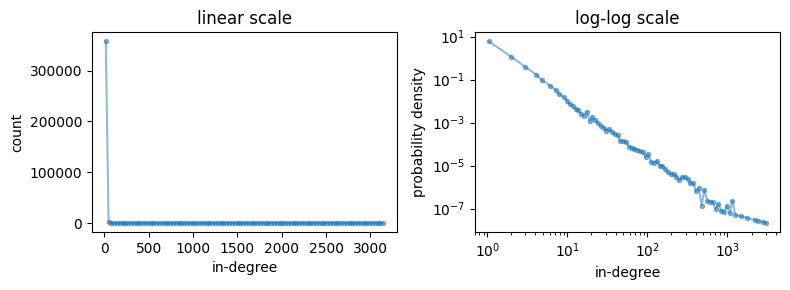

In [91]:
LogAndLinearHist(in_degree, xlabel='in-degree')

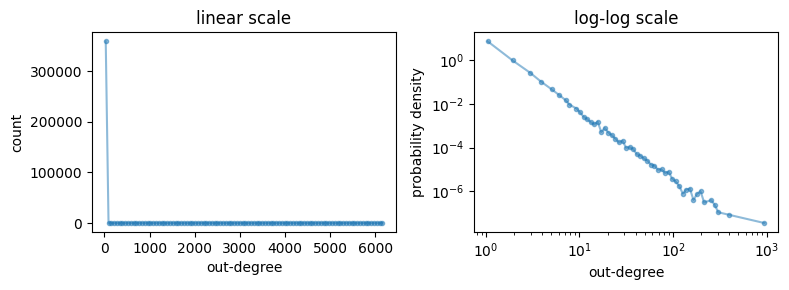

In [92]:
LogAndLinearHist(out_degree, xlabel='out-degree')

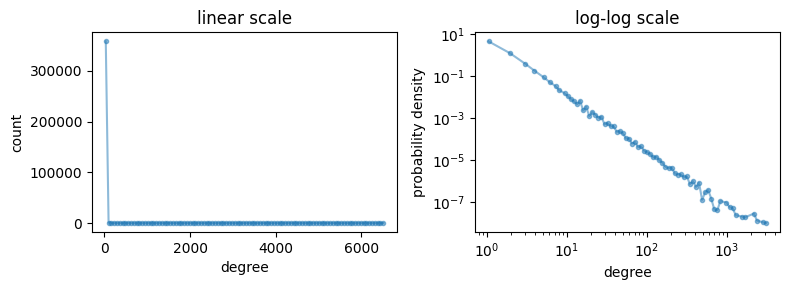

In [93]:
LogAndLinearHist(degree, xlabel='degree')

In [96]:
temp = pd.DataFrame([in_degree, out_degree, degree], index=['in-degree', 'out-degree', 'degree']).T

In [98]:
temp.describe()

,in-degree,out-degree,degree
count,359252.000000,359252.000000,359252.000000
mean,2.001993,2.001993,4.003986
std,14.013937,11.068325,19.140409
min,0.000000,0.000000,1.000000
25%,0.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,4.000000
max,3161.000000,6186.000000,6544.000000
